# Notebook to match VASCA sources to SIMBAD database sources positionally
Set your option in the cell bellow

In [1]:
from astropy import units as uu
region_name = "WD" #"MDIS_10-800" #"TDS" #  _ELAISN1
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"
simbad_query = True
query_radius = 2 * uu.arcsec
match_radius = 1 * uu.arcsec

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
from astropy.table import unique, Table, hstack, join, setdiff
import numpy as np
from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from vasca.tables import TableCollection, dd_vasca_columns
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col, get_col_cycler
from astroquery.simbad import Simbad
from itertools import cycle
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
import numpy.ma as ma
#import matplotlib as mpl
from cycler import cycler

#prepare file names

#assocs_fname = "./vasca_pipeline/"+region_name+"/assocs_"+region_name+".fits"

# Get region and source coordinates
rg = Region()
rg.load_from_fits(region_fname)
#rg.set_hardness_ratio()
sel_src = rg.tt_sources["sel"]
tt_src = rg.tt_sources[sel_src]
display(tt_src[0:2])

# Add object group ID
def add_ogrp(tc,tt_name):
    "Helper funtion to add ogrp:id column to tables"
    tt = tc.__dict__[tt_name]
    tc.add_column(tt_name,"ogrp")
    has_mask = ma.is_masked(tt["otype"].data)
    for ii in range(len(tt)):
        if has_mask and tt["otype"].mask[ii]:
            tt["otype"][ii]="none"
            tt["otype"].mask[ii] = False
        tt["ogrp"][ii] = otype2ogroup(tt["otype"][ii])

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32
-1,35 .. 12,215.7578797138266,52.55472889656352,0.0969887,-0.10515972,0.3684073,0.11797173,0.7773258,2172,0.1463604,1 .. 2,True,13.552042 .. 5.0590057,0.13476102 .. 0.2489886,0.14390667 .. 0.36439636,27.175077 .. 10.378859,0.0 .. 1.5987431e-26,44.26484 .. 13.622811,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,31,6,0.36955848,0.019991705
-1,170 .. 46,215.57187273530468,53.03654526099138,0.04660307,-0.065545194,0.43132085,0.0005818189,0.840598,130,0.15241942,1 .. 2,True,13.527031 .. 3.8372507,0.060915094 .. 0.10942257,0.009331437 .. -0.009241477,2.4011583 .. 0.47210523,0.0 .. 0.7785344,3.8307788 .. 0.83346456,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,67,6,0.28451157,0.0096034


### Query the SIMBAD data or read from file

In [3]:
# Get matches
#mt = TableCollection()
if simbad_query:
    print("Query to SIMBAD ...")
    # Run query
    src_coord = SkyCoord(tt_src["ra"].quantity,tt_src["dec"].quantity,frame='icrs')
    customSimbad = Simbad()
    customSimbad.TIMEOUT = 180
    vo_entries = ['otype',"otype(opt)","otypes", 'distance', "distance_result","velocity","z_value"]   # ,"propermotions"
    customSimbad.add_votable_fields(*vo_entries)
    tt_simbad = customSimbad.query_region(src_coord,radius=query_radius)
    
    # Change type to be handabel by astropy
    vo_change_type = ["MAIN_ID","COO_BIBCODE","OTYPE","OTYPE_opt","OTYPES", "RVZ_BIBCODE"]  # "PM_BIBCODE"
    for vo in vo_change_type:
        tt_simbad[vo] = tt_simbad[vo].data.astype("S32")

    # Write simbad and source info into matching tables
    src_idx = tt_simbad["SCRIPT_NUMBER_ID"]-1
    tt_simbad["rg_src_id"] = tt_src[src_idx]["rg_src_id"]
    tt_simbad["match_id"] = np.array(range(0,len(tt_simbad)), dtype= np.int32)
    tt_simbad.rename_column('OTYPE_opt', 'otype')
else:
    tt_simbad = Table.read(region_fname, hdu="tt_simbad")
tt_simbad.sort(['rg_src_id', 'DISTANCE_RESULT'])
rg.add_table(tt_simbad,"tt_simbad")
display(rg.tt_simbad[:2])

Query to SIMBAD ...


/home/buehler/mambaforge/envs/vas/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 22 raised an error (recorded in the `errors` attribute of the result table): '14:20:17.63117005 +52:29:32.19620636': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "
/home/buehler/mambaforge/envs/vas/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 61 raised an error (recorded in the `errors` attribute of the result table): '14:24:51.76007878 +52:57:59.24951948': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,OTYPE,otype,OTYPES,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,DISTANCE_RESULT,RVZ_TYPE,RVZ_RADVEL,RVZ_ERROR,RVZ_QUAL,RVZ_WAVELENGTH,RVZ_BIBCODE,Z_VALUE,SCRIPT_NUMBER_ID,rg_src_id,match_id
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,,,,,,,arcsec,,km / s,km / s,,,,,,,
bytes32,str13,str13,int16,int16,float32,float32,int16,str1,str1,bytes32,bytes32,bytes32,bytes32,float64,str1,str4,float64,float64,str8,str19,float32,str1,float64,float32,str1,str1,bytes32,float64,int32,int32,int32
[CBH2010] 215.757919+52.554806,14 23 01.8669,+52 33 16.606,14,14,0.599,0.557,90,A,O,2020yCat.1350....0G,QSO,QSO,AGN|QSO|QSO|QSO|AGN|*|G|Opt,--,,,--,--,,,0.4717,z,0.845,--,D,O,2018A&A...613A..51P,0.8450000,1,31,0
SDSS J142217.19+530211.2,14 22 17.1897,+53 02 11.150,14,14,0.423,0.428,90,A,O,2020yCat.1350....0G,QSO,QSO,AGN|QSO|QSO|QSO|QSO|AGN|*|G|Opt,--,,,--,--,,,0.6783,z,0.896,--,D,O,2018A&A...613A..51P,0.8960000,2,67,1


### Create matching table

In [4]:
# Create simbad table with best match on top
# Take the closest match
mt_sim_cols = ["rg_src_id","otype","MAIN_ID","OTYPES","Z_VALUE","Distance_distance","Distance_unit","DISTANCE_RESULT"]
tt_simbad_grp =  rg.tt_simbad.group_by('rg_src_id')
mult_match = 0
for key, tt_grp in zip(tt_simbad_grp.groups.keys, tt_simbad_grp.groups):
    sel_dist = tt_grp['DISTANCE_RESULT']< match_radius
    if sel_dist.sum()>1:
        mult_match += 1
print(f"Nr of sources with several possible associations within matching radius: {mult_match} / {len(tt_simbad_grp.groups.keys)} / {len(tt_src)} / {len(rg.tt_sources)}")
tu_simbad = unique(tt_simbad_grp, keys="rg_src_id")

Nr of sources with several possible associations within matching radius: 3 / 58 / 62 / 62


In [5]:
mt_vas_cols = ["rg_src_id","pos_err","ra","dec","obs_filter_id","flux","flux_err","flux_nxv","hr","hr_err","nr_det", "sel"]
tt_match = join(tt_src,tu_simbad[mt_sim_cols], keys='rg_src_id',join_type='outer')
display(tt_match)

#Select only sources with countrparts within a given radius
sel_query = ~tt_match['DISTANCE_RESULT'].mask
tt_match["sel"] = sel_query
tt_match["sel"][tt_match["sel"]] = tt_match['DISTANCE_RESULT'][tt_match["sel"]]< match_radius
sel_mt = tt_match["sel"]

#Add tables to table collection
rg.add_table(tt_match,"tt_sources")

# Add object group
add_ogrp(rg,"tt_sources")

display(rg.tt_sources)
#Write and show
#rg.write_to_fits(region_fname)


fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,otype,MAIN_ID,OTYPES,Z_VALUE,Distance_distance,Distance_unit,DISTANCE_RESULT
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,,,arcsec
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,bytes32,bytes32,bytes32,float64,float64,str4,float32
-1,35 .. 12,215.7578797138266,52.55472889656352,0.0969887,-0.10515972,0.3684073,0.11797173,0.7773258,2172,0.1463604,1 .. 2,True,13.552042 .. 5.0590057,0.13476102 .. 0.2489886,0.14390667 .. 0.36439636,27.175077 .. 10.378859,0.0 .. 1.5987431e-26,44.26484 .. 13.622811,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,31,6,0.36955848,0.019991705,QSO,[CBH2010] 215.757919+52.554806,AGN|QSO|QSO|QSO|AGN|*|G|Opt,0.8450000,--,,0.4717
-1,170 .. 46,215.57187273530468,53.03654526099138,0.04660307,-0.065545194,0.43132085,0.0005818189,0.840598,130,0.15241942,1 .. 2,True,13.527031 .. 3.8372507,0.060915094 .. 0.10942257,0.009331437 .. -0.009241477,2.4011583 .. 0.47210523,0.0 .. 0.7785344,3.8307788 .. 0.83346456,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,67,6,0.28451157,0.0096034,QSO,SDSS J142217.19+530211.2,AGN|QSO|QSO|QSO|QSO|AGN|*|G|Opt,0.8960000,--,,0.6783
-1,135 .. 68,215.53824492083686,53.099799252451675,0.04330824,0.0229016,0.41452467,0.107102014,1.0326743,153,0.78585744,1 .. 2,True,35.435486 .. 14.458667,0.09978798 .. 0.15735698,0.06931123 .. 0.025061248,88.579765 .. 7.070185,0.0 .. 1.1106611e-34,56.49397 .. 4.777942,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,77,6,0.41823706,0.0057854126,QSO,SDSS J142209.13+530559.7,QSO|AGN|QSO|QSO|QSO|QSO|AGN|*|G|,0.7550000,--,,0.5360
-1,134 .. 50,215.46305329295978,52.83074383786214,0.055545524,0.059869178,0.6485116,0.00010052279,1.0778353,212,0.29788187,1 .. 2,True,7.235762 .. 5.996281,0.057358414 .. 0.1186625,0.03100316 .. 0.075938195,2.0991583 .. 3.477642,0.0 .. 3.5964955e-28,5.041884 .. 5.035403,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,99,6,0.83977437,0.023141544,G,[GBM2008] D3-29,EmG|G|G|UV,0.2021000,--,,0.5865
-1,119 .. 45,215.43286115443865,52.38623227639242,0.056937516,0.051149182,0.62891746,0.2317302,0.99982226,237,0.21259339,1 .. 2,True,11.482638 .. 3.6266046,0.06884844 .. 0.108395144,0.013418611 .. 0.018622022,2.4011786 .. 0.9084332,4.36762e-40 .. 0.19567347,3.8045034 .. 1.1773078,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,106,6,0.30737695,0.011487613,QSO,SDSS J142143.81+522308.9,QSO|QSO|QSO|QSO|AGN|*|Opt,1.2890000,--,,1.7490
-1,165 .. 67,215.39972991190294,52.52751602616712,0.040147517,-0.053809952,0.33037305,0.002859528,0.82504463,276,0.08342701,1 .. 2,True,28.47718 .. 25.26502,0.08504929 .. 0.19666068,0.07729933 .. 0.100803316,64.0591 .. 67.140236,0.0 .. 0.0,44.080437 .. 27.337791,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,116,6,0.8634102,0.009653168,Sy1,Anon J142135+5231,AGN|AGN|Sy1|QSO|QSO|QSO|QSO|QSO|,0.2490000,--,,0.3601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,194 .. -1,214.567876212931,52.4947750822241,0.048629533,-0.26893687,0.19149211,0.9999934,0.4153868,4693,0.12923843,1 .. 0,True,7.7024965 .. -1.0,0.049014524 .. -1.0,0.023200594 .. -100.0,1.892706 .. -1.0,0.0 .. -1.0,3.3166258 .. -1.0,-100.0 .. 1.0,-10000.0 .. 0.0,-1,2987,2,-1.0,-1.0,QSO,[VV96] J141816.2+522940,QSO|AGN|QSO|QSO|QSO|AGN|QSO|*|G|,1.6080000,--,,0.6606


fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,otype,MAIN_ID,OTYPES,Z_VALUE,Distance_distance,Distance_unit,DISTANCE_RESULT,ogrp
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,,,arcsec,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,bytes32,bytes32,bytes32,float64,float64,str4,float32,bytes8
-1,35 .. 12,215.7578797138266,52.55472889656352,0.0969887,-0.10515972,0.3684073,0.11797173,0.7773258,2172,0.1463604,1 .. 2,True,13.552042 .. 5.0590057,0.13476102 .. 0.2489886,0.14390667 .. 0.36439636,27.175077 .. 10.378859,0.0 .. 1.5987431e-26,44.26484 .. 13.622811,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,31,6,0.36955848,0.019991705,QSO,[CBH2010] 215.757919+52.554806,AGN|QSO|QSO|QSO|AGN|*|G|Opt,0.8450000,--,,0.4717,AGN
-1,170 .. 46,215.57187273530468,53.03654526099138,0.04660307,-0.065545194,0.43132085,0.0005818189,0.840598,130,0.15241942,1 .. 2,True,13.527031 .. 3.8372507,0.060915094 .. 0.10942257,0.009331437 .. -0.009241477,2.4011583 .. 0.47210523,0.0 .. 0.7785344,3.8307788 .. 0.83346456,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,67,6,0.28451157,0.0096034,QSO,SDSS J142217.19+530211.2,AGN|QSO|QSO|QSO|QSO|AGN|*|G|Opt,0.8960000,--,,0.6783,AGN
-1,135 .. 68,215.53824492083686,53.099799252451675,0.04330824,0.0229016,0.41452467,0.107102014,1.0326743,153,0.78585744,1 .. 2,True,35.435486 .. 14.458667,0.09978798 .. 0.15735698,0.06931123 .. 0.025061248,88.579765 .. 7.070185,0.0 .. 1.1106611e-34,56.49397 .. 4.777942,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,77,6,0.41823706,0.0057854126,QSO,SDSS J142209.13+530559.7,QSO|AGN|QSO|QSO|QSO|QSO|AGN|*|G|,0.7550000,--,,0.5360,AGN
-1,134 .. 50,215.46305329295978,52.83074383786214,0.055545524,0.059869178,0.6485116,0.00010052279,1.0778353,212,0.29788187,1 .. 2,True,7.235762 .. 5.996281,0.057358414 .. 0.1186625,0.03100316 .. 0.075938195,2.0991583 .. 3.477642,0.0 .. 3.5964955e-28,5.041884 .. 5.035403,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,99,6,0.83977437,0.023141544,G,[GBM2008] D3-29,EmG|G|G|UV,0.2021000,--,,0.5865,GAL
-1,119 .. 45,215.43286115443865,52.38623227639242,0.056937516,0.051149182,0.62891746,0.2317302,0.99982226,237,0.21259339,1 .. 2,False,11.482638 .. 3.6266046,0.06884844 .. 0.108395144,0.013418611 .. 0.018622022,2.4011786 .. 0.9084332,4.36762e-40 .. 0.19567347,3.8045034 .. 1.1773078,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,106,6,0.30737695,0.011487613,QSO,SDSS J142143.81+522308.9,QSO|QSO|QSO|QSO|AGN|*|Opt,1.2890000,--,,1.7490,AGN
-1,165 .. 67,215.39972991190294,52.52751602616712,0.040147517,-0.053809952,0.33037305,0.002859528,0.82504463,276,0.08342701,1 .. 2,True,28.47718 .. 25.26502,0.08504929 .. 0.19666068,0.07729933 .. 0.100803316,64.0591 .. 67.140236,0.0 .. 0.0,44.080437 .. 27.337791,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,116,6,0.8634102,0.009653168,Sy1,Anon J142135+5231,AGN|AGN|Sy1|QSO|QSO|QSO|QSO|QSO|,0.2490000,--,,0.3601,AGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,194 .. -1,214.567876212931,52.4947750822241,0.048629533,-0.26893687,0.19149211,0.9999934,0.4153868,4693,0.12923843,1 .. 0,True,7.7024965 .. -1.0,0.049014524 .. -1.0,0.023200594 .. -100.0,1.892706 .. -1.0,0.0 .. -1.0,3.3166258 .. -1.0,-100.0 .. 1.0,-10000.0 .. 0.0,-1,2987,2,-1.0,-1.0,QSO,[VV96] J141816.2+522940,QSO|AGN|QSO|QSO|QSO|AGN|QSO|*|G|,1.6080000,--,,0.6606,AGN


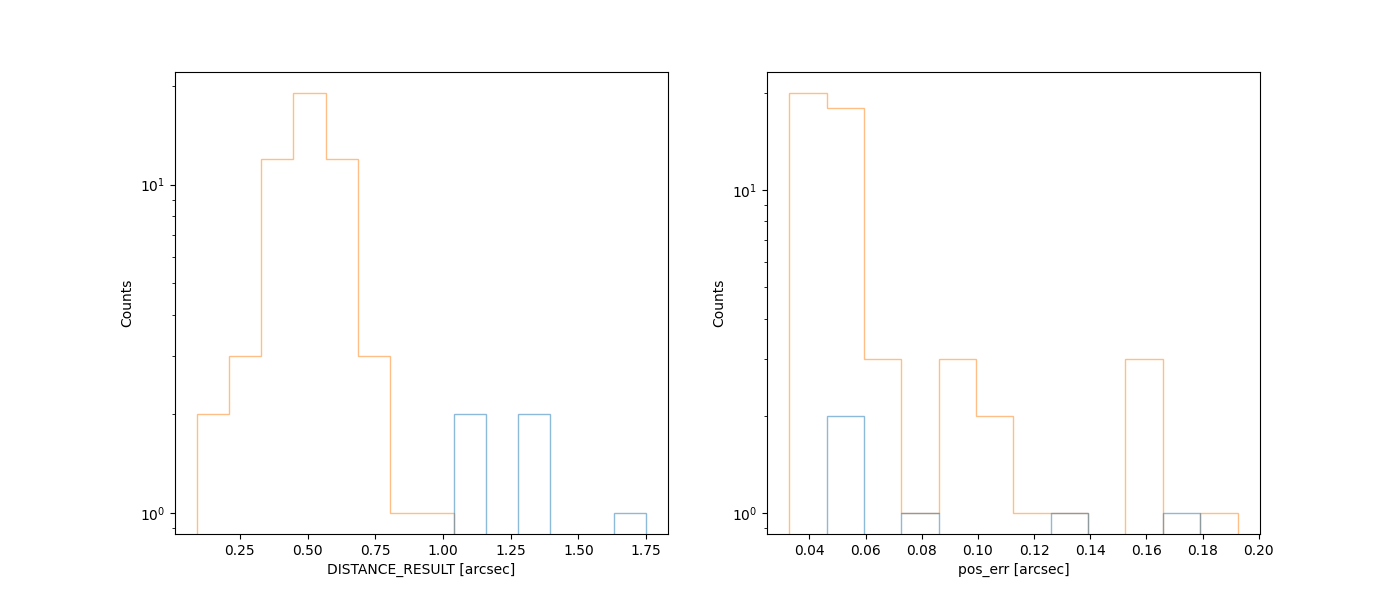

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs = np.array(axs).flatten()
_ = vvis.plot_table_hist(rg.tt_sources[sel_query], 'DISTANCE_RESULT', ax=axs[0], logx=False, obs_filter_id=None, density= False)
_ = vvis.plot_table_hist(rg.tt_sources[sel_query], 'pos_err', ax=axs[1], logx=False, obs_filter_id=None, density= False)

### Plot found object types

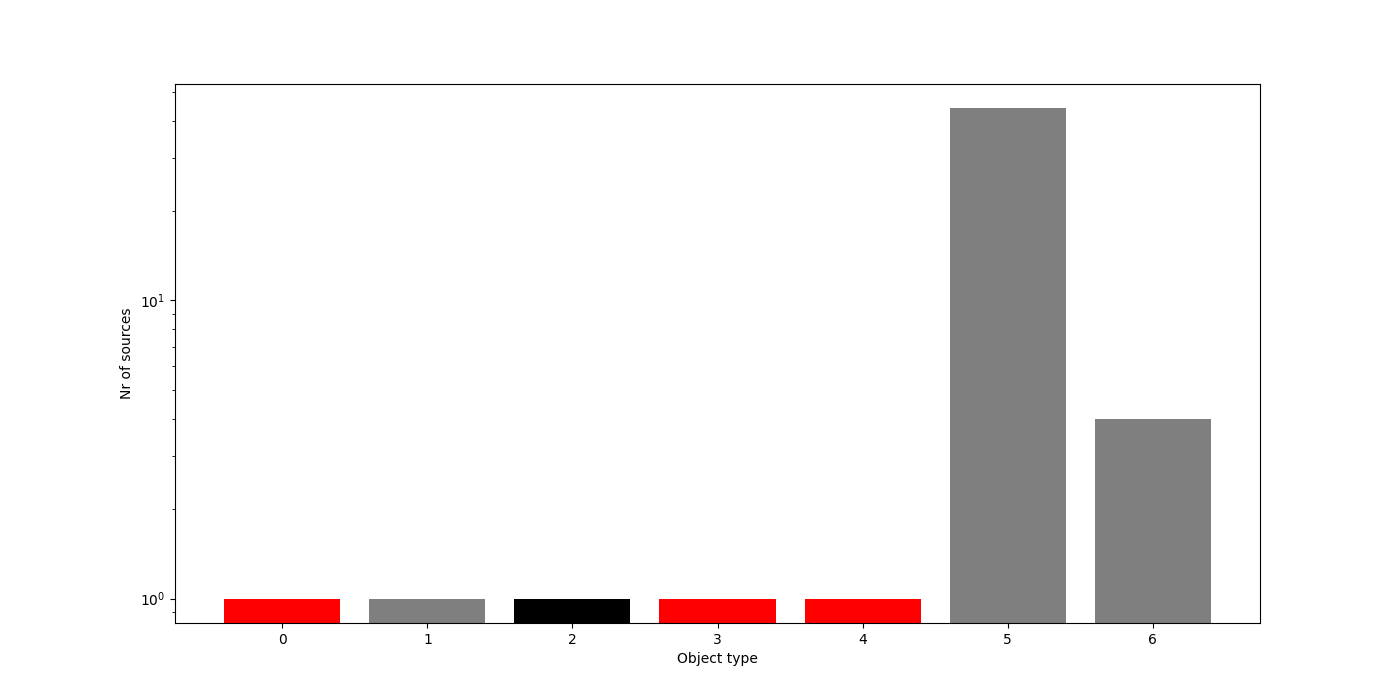

otype Candidate      Description       ogrp   Label            Category                                Subcategory                         
                                                                                                                                           
----- --------- ---------------------- ---- ---------- ----------------------- ------------------------------------------------------------
    *        --                   Star Star       Star    1. TAXONOMY OF STARS                                                           --
  AGN       AG?  Active Galaxy Nucleus  AGN        AGN 4. TAXONOMY OF GALAXIES                                                           --
    G        G?                 Galaxy  GAL     Galaxy 4. TAXONOMY OF GALAXIES                                                           --
  HB*       HB? Horizontal Branch Star Star HorBranch*    1. TAXONOMY OF STARS                                                Evolved Stars
  Pu*       Pu?     

In [7]:
fig_otypes = plt.figure("Source types",figsize=(14, 7))
fig_otypes.clf()

otypes_all, otype_cts_all= np.unique(rg.tt_sources[sel_mt]["otype"],return_counts=True)
dd_otype2id = dict(zip(list(otypes_all),range(len(otypes_all))))

tt_mt_grp =  rg.tt_sources[sel_mt].group_by("ogrp")
for group, tt_grp in zip(tt_mt_grp.groups.keys, tt_mt_grp.groups):
    otypes, otype_cts= np.unique(tt_grp["otype"],return_counts=True)
    otypes_id = []
    for otype in otypes:
        otypes_id.append(dd_otype2id[otype])
    plt.bar( otypes_id, otype_cts, align='center', label=group[0], color = dd_ogrp2col[group[0]])
plt.yscale('log')
#plt.grid()
plt.xlabel("Object type")
plt.ylabel("Nr of sources")
plt.show()
plt.legend()
plt.xticks(range(len(otypes_all)), otypes_all, size='small')


tt_nodes = Table.read('./resources/SIMBAD_otypes/otypes_nodes.csv') #, format='ascii.daophot'
ids, ids_idx, _ = np.intersect1d(tt_nodes["Id"],np.array(otypes_all),return_indices=True)
candidate = np.asarray(np.ma.masked_array(data = tt_nodes["Candidate"],mask = False, fill_value = "none"))
can, can_idx, _ = np.intersect1d(candidate,np.array(otypes),return_indices=True)
all_idx = np.unique(np.append(ids_idx,can_idx))
tt_nodes.rename_column('Id', 'otype')
rg.add_table(tt_nodes[all_idx],"tt_otypes")
add_ogrp(rg,"tt_otypes")
rg.tt_otypes["otype","Candidate","Description","ogrp","Label","Category","Subcategory"].pprint_all()#show_dtype=True #,"Status","Priority"
rg.write_to_fits(region_fname)

### Scatter plots of source variables by group

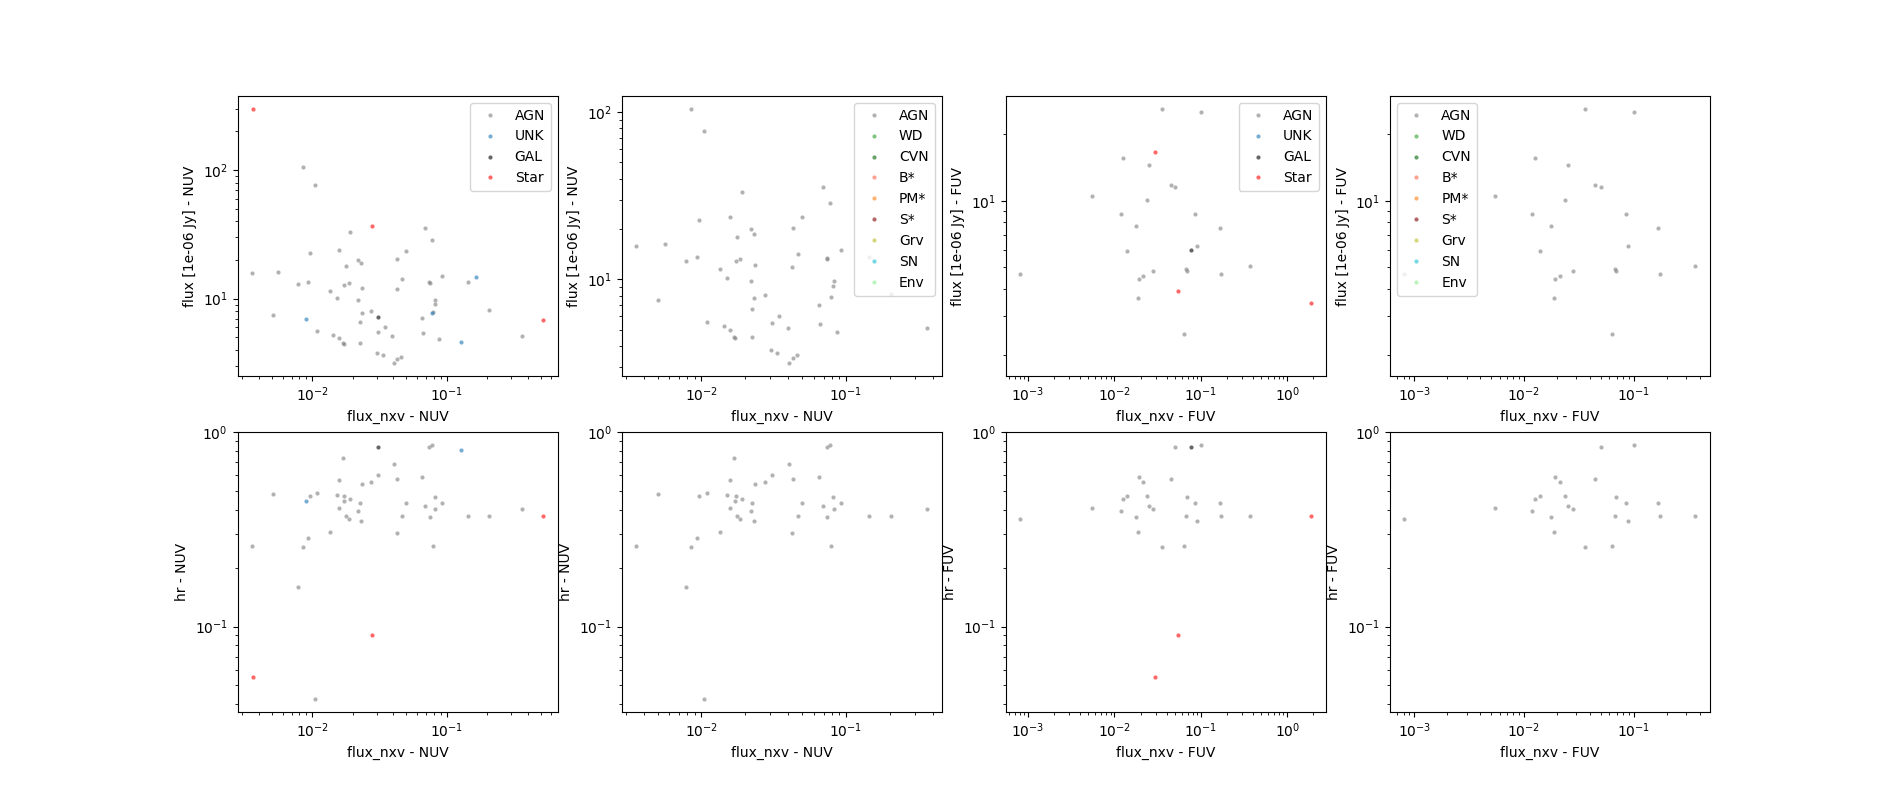

In [8]:
plot_kwargs = {"markersize": 3.0,"alpha":0.6}
fig, axs = plt.subplots(2, 4, figsize=(19, 8))
#fig.clf()
axs = axs.flatten()
plt_ogrops = [["AGN","UNK","GAL",'Star'],["AGN",'WD', 'CVN', 'B*', 'PM*',"S*", 'Grv', 'SN',"Env"]]

plt_flts = [1,2]
ctr = 0
for flt in plt_flts:
    for ogrps in plt_ogrops:
        #axs[ctr].cla()
        axs[ctr].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rg.tt_sources,"flux_nxv", "flux", ax=axs[ctr], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)

        #axs[ctr+4].cla()
        axs[ctr+4].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rg.tt_sources,"flux_nxv", "hr", ax=axs[ctr+4], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)
        ctr +=1

_ = axs[0].legend()
_ = axs[1].legend()
_ = axs[2].legend()
_ = axs[3].legend()
#print(dd_ogrp2otypes.keys())r

### Print info for selected sources

In [9]:
# Make selection
sel_otype = rg.tt_sources["otype"] ==  "RR*"# "No*"#"HS?" #"BS*" #"PM*" # # "SN*" #"EB*"
sel_otypes = (rg.tt_sources["otype"] ==  "WD?")  + (rg.tt_sources["otype"] =="WD*")
sel_flux_nxv = rg.tt_sources["flux_nxv"][:,0]>2
sel_flux_hr = rg.tt_sources["hr"]>2
sel_src_id = rg.tt_sources["rg_src_id"]==15179
sel_srcs =  sel_otypes  #sel_src_id  #sel_flux_nxv #sel_otype # sel_flux_nxv_fuv # sel_flux_hr#

#Display match and simbad table for selected sources
display(rg.tt_sources[sel_srcs])

#Print oout list of source IDs to be used for further use, e.g. in inspect_sources.ipynb
print("srcs_ids = [", end="")
for src_id in rg.tt_sources[sel_srcs]["rg_src_id"].data:
    print(src_id,",", end="")
print("]")

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,otype,MAIN_ID,OTYPES,Z_VALUE,Distance_distance,Distance_unit,DISTANCE_RESULT,ogrp
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,,,arcsec,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,bytes32,bytes32,bytes32,float64,float64,str4,float32,bytes8


srcs_ids = []


Identified sources:
1) 150.38873296492392	1.7245661255048343; GNU2605264352416104448 PS_COSMOS_MOS26; LINEAR 21145823;RR*;Very large flux_nxv_fuv=47 and very low hr 0.026; 

In [10]:
from astroquery.simbad import Simbad

testSimbad = Simbad()

#testSimbad.list_votable_fields()
all_vo_fields = ["biblio","cel","cl.g","coo(opt)","coo_bibcode","coo_err_angle","coo_err_maja","coo_err_mina","coo_qual","coo_wavelength","coordinates","dec(opt)","dec_prec","diameter","dim","dim_angle","dim_bibcode","dim_incl","dim_majaxis","dim_minaxis","dim_qual","dim_wavelength","dimensions","distance","distance_result","einstein","fe_h","flux(filtername)","flux_bibcode(filtername)","flux_error(filtername)","flux_name(filtername)","flux_qual(filtername)","flux_system(filtername)","flux_unit(filtername)","fluxdata(filtername)","gcrv","gen","gj","hbet","hbet1","hgam","id(opt)","ids","iras","irc","iso","iue","jp11","link_bibcode","main_id","measurements","membership","mesplx","mespm","mk","morphtype","mt","mt_bibcode","mt_qual","otype","otype(opt)","otypes","parallax","plx","plx_bibcode","plx_error","plx_prec","plx_qual","pm","pm_bibcode","pm_err_angle","pm_err_maja","pm_err_mina","pm_qual","pmdec","pmdec_prec","pmra","pmra_prec","pos","posa","propermotions","ra(opt)","ra_prec","rot","rv_value","rvz_bibcode","rvz_error","rvz_qual","rvz_radvel","rvz_type","rvz_wavelength","sao","sp","sp_bibcode","sp_nature","sp_qual","sptype","td1","typed_id","ubv","uvby","uvby1","v*","velocity","xmm","z_value"]

for vo_field in all_vo_fields:
    print("*",vo_field)
    testSimbad.get_field_description(vo_field)

* biblio
all bibcodes of an astronomical object separated with a ipipe
* cel
Celescope catalog of ultra-violet photometry
* cl.g
Cluster of Galaxies: Abell & Corwin,Astrophys. J. Suppl.,70,1 (1989)
* coo(opt)
d : decimal display
s : sexagesimal display
frame : ICRS, FK5, FK4, GAL, SGAL, ECL
epoch : epoch (decimal value) for the coordinates display
equinox : equinox (decimal value) for the coordinates display
* coo_bibcode
bibliographical reference
* coo_err_angle
angle of the error ellipse
* coo_err_maja
major axis of the error ellipse
* coo_err_mina
minor axis of the error ellipse
* coo_qual
quality (A:astrometric, .., E:unknown)
* coo_wavelength
wavelength type of the measure (Radio, IR, Visible, UV, X, Gamma)
* coordinates
all fields related with coordinates
* dec(opt)
declination. The options are the same as for coo above.
* dec_prec
declination precision code (0:1/10deg, ..., 8: 1/1000 arcsec)
* diameter
Stellar diameters, see 2001A&A...367..521P for an explanation of the coding 
